In [94]:
import random
from matplotlib import pyplot as plt


In [95]:
# open the file datasetv2.txt and read each line
# with open('datasetv2.txt') as f:
with open('data/sls/imdb_labelled.txt') as f:
    lines = f.read().splitlines()

lines[:5]

['A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  \t0',
 'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  \t0',
 'Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  \t0',
 'Very little music or anything to speak of.  \t0',
 'The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.  \t1']

In [96]:
# remove comma, period, question mark and exclamation mark, and convert each line to lowercase

lines = [line.lower()
         .replace(',', '')
         .replace('.', '')
         .replace('?', '')
         .replace('!', '') 
         .replace('-', '')
         .replace('/', ' ')
         for line in lines]

# a list of dictionaries, where each dictionary contains the text and label of a line
train_set = []
for line in lines:
    text, label = line.split('\t')
    train_set.append({'text': text, 'label': int(label)})


train_set[:5]

[{'text': 'a very very very slowmoving aimless movie about a distressed drifting young man  ',
  'label': 0},
 {'text': 'not sure who was more lost  the flat characters or the audience nearly half of whom walked out  ',
  'label': 0},
 {'text': 'attempting artiness with black & white and clever camera angles the movie disappointed  became even more ridiculous  as the acting was poor and the plot and lines almost nonexistent  ',
  'label': 0},
 {'text': 'very little music or anything to speak of  ', 'label': 0},
 {'text': 'the best scene in the movie was when gerardo is trying to find a song that keeps running through his head  ',
  'label': 1}]

In [97]:
dict_word_freq = {}


for line in lines:
    # add each word as the key and its frequency as the value
    for word in line.split():
        # if the word is not in the dictionary, add it
        if word not in dict_word_freq:
            dict_word_freq[word] = 1
        # if the word is in the dict_word_freq, increment its value by 1
        else:
            dict_word_freq[word] += 1

print(f"Number of words = {len(dict_word_freq.items())}")

Number of words = 3308


In [98]:
# Preprocessing and cleaning the data
# remove frequent words and rare words, and remove words with length less than 3

# remove frequent words that appear more than 80% of the time
dict_word_freq = {k: v for k, v in dict_word_freq.items() if v < 0.8 * len(lines)}

# remove rare words that appear less than 5 times
dict_word_freq = {k: v for k, v in dict_word_freq.items() if v > 2}

# remove words with length less than 3
dict_word_freq = {k: v for k, v in dict_word_freq.items() if len(k) > 3}

print(f"Number of words after cleanup = {len(dict_word_freq.items())}")

Number of words after cleanup = 596


In [99]:
words = [*dict_word_freq.keys()]
random.choices(words, k=10)

['that',
 "it's",
 'found',
 'which',
 'wrong',
 'drago',
 'wish',
 'brilliance',
 'here',
 'main']

In [105]:
def newIndividual(words, size):
    # create an individual by randomly choosing words from the list of words
    return random.choices(words, k=size)

def mutate(individual, words, mutation_rate):
    # mutate the individual by randomly changing some of its words
    for i in range(len(individual)):
        if random.random() < mutation_rate: # random.random() returns a random float between 0 and 1 === probability
            individual[i] = random.choice(words)
    return individual

def fitness(individual, train_set):
    # the individual is a list of words like ['C1-1', 'C1-2', ..., 'C0-N/2', 'C0-1', 'C0-2', ..., 'C0-N/2']
    # fitness funtion is calculated by counting the number of times the individual appears in the lines
    count_c1, count_c0 = 0, 0
    count_correct_prediction = 0
    for line in train_set:
        line, label = line["text"], line["label"]
        for word in line.split():
            if word in individual[:len(individual)//2]: # if it is in the first half of the individual
                count_c1 += 1
            elif word in individual[len(individual)//2:]: # if it is in the second half of the individual
                count_c0 += 1
    
        prediction = 1 if count_c1 >= count_c0 else 0
        if prediction == label: # if the prediction is correct
            count_correct_prediction += 1
    return count_correct_prediction / len(train_set)
        

def crossover(parent1, parent2):
    # create a child by randomly choosing genes from the parents
    child_genes = []
    for i in range(len(parent1)):
        if random.random() < 0.5:
            child_genes.append(parent1[i])
        else:
            child_genes.append(parent2[i])
    return child_genes

def geneticAlgorithm(train_set, population_size, individual_size, mutation_rate, elitism_rate= 0.2, max_generations=1000, verbose=True):
    # Genetic Algorithm

    # create the initial population
    population = [newIndividual(words, size=individual_size) for _ in range(population_size)]
    # sort the population by fitness
    population = sorted(population, key=lambda individual: fitness(individual, train_set), reverse=True)
    # keep track of the best individual
    best_individual = population[0]
    # keep track of the fitness of the best individual in each generation
    best_fitness = [fitness(best_individual, train_set)]
    # keep track of the average fitness of the population in each generation
    avg_fitness = [sum([fitness(individual, train_set) for individual in population]) / population_size]
    # keep track of the number of generations
    num_generation = 0
    while num_generation < max_generations:
        # create the next generation
        next_generation = []
        # keep the best individuals in the population
        next_generation.extend(population[:int(elitism_rate * population_size)])
        # create the rest of the population
        while len(next_generation) < population_size:
            # randomly choose two parents from the current population
            parent1, parent2 = random.choices(population, k=2)
            # create a child by crossover
            child = crossover(parent1, parent2)
            # mutate the child
            child = mutate(child, words, mutation_rate)
            # add the child to the next generation
            next_generation.append(child)
        # sort the next generation by fitness
        next_generation = sorted(next_generation, key=lambda individual: fitness(individual, train_set), reverse=True)
        # update the population
        population = next_generation
        # update the best individual
        if fitness(population[0], train_set) > fitness(best_individual, train_set):
            best_individual = population[0]
        # update the best fitness
        best_fitness.append(fitness(best_individual, train_set))
        # update the average fitness
        avg_fitness.append(sum([fitness(individual, train_set) for individual in population]) / population_size)
        # update the number of generations

        if verbose==True and (num_generation % ( max_generations // 10) == 0) :
            print(f"Gen {num_generation+1}: Best fitness = {best_fitness[-1]}, Avg fitness = {avg_fitness[-1]}")
            print(f"Best individual = {best_individual}")

        num_generation += 1
    print(f"==== summary ====")
    print(f"Hyperparameters:")
    print(f"\tPopulation size = {population_size}")
    print(f"\tIndividual size = {individual_size}")
    print(f"\tMutation rate = {mutation_rate}")
    print(f"\tElitism rate = {elitism_rate}")
    print(f"Algorithm finished after {max_generations} generations")
    print(f"Best individual = {best_individual}")
    return best_individual, best_fitness, avg_fitness

In [106]:
population_size = 100
individual_size = 10
mutation_rate = 0.05

best_individual, best_fitness, avg_fitness = geneticAlgorithm(train_set, 
                                                              population_size, 
                                                              individual_size, 
                                                              mutation_rate, 
                                                              elitism_rate=0.1, 
                                                              max_generations=50)

Gen 1: Best fitness = 0.588, Avg fitness = 0.5011599999999999
Best individual = ['photography', 'insult', 'story', 'seeing', 'journey', 'sense', 'actors', 'example', 'episode', 'negative']
Gen 6: Best fitness = 0.597, Avg fitness = 0.51609
Best individual = ['done', 'their', 'them', 'kids', 'short', 'girl', 'little', 'screen', 'found', 'negative']
Gen 11: Best fitness = 0.606, Avg fitness = 0.5227400000000001
Best individual = ['enough', 'music', 'song', 'memories', 'documentary', 'same', 'whatever', 'average', 'found', 'memories']
Gen 16: Best fitness = 0.625, Avg fitness = 0.5231699999999999
Best individual = ['favourite', 'subtle', 'piece', 'actresses', 'completely', 'same', 'screenwriter', 'especially', 'already', 'negative']
Gen 21: Best fitness = 0.629, Avg fitness = 0.5366400000000001
Best individual = ['camera', 'grace', 'song', 'clever', 'guess', 'easily', 'money', 'making', 'found', 'effective']
Gen 26: Best fitness = 0.629, Avg fitness = 0.5305600000000001
Best individual = 

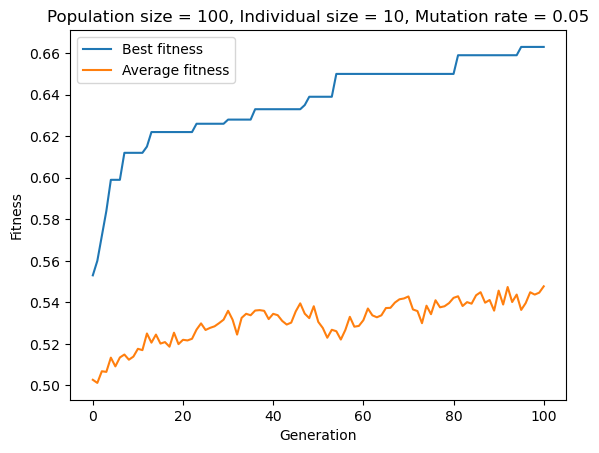

In [104]:
# plot the fitness
plt.plot(best_fitness, label="Best fitness")
plt.plot(avg_fitness, label="Average fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")

# name of the plot containing the parameters
plt.title(f"Population size = {population_size}, Individual size = {individual_size}, Mutation rate = {mutation_rate}")
plt.legend()
plt.show()